[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/franckalbinet/mirzai/blob/main/nbs/paper/10_interpretation_gradshap.ipynb)

# 6.1. GradientShap values

> Calculating features (wavenumbers) importance for the CNN

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive',  force_remount=False)
    !pip install mirzai
else:
    %load_ext autoreload
    %autoreload 2

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 12.5 MB/s 
     |████████████████████████████████| 1.4 MB 81.6 MB/s 
     |████████████████████████████████| 957 kB 48.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
# Python utils
import math
from collections import OrderedDict
from tqdm.auto import tqdm
from pathlib import Path
import pickle

# mirzai utilities
from mirzai.data.loading import load_kssl
from mirzai.data.selection import (select_y, select_tax_order, select_X)
from mirzai.data.transform import (log_transform_y, SNV)
from mirzai.data.selection import get_y_by_order
from mirzai.training.cnn import Model
from mirzai.vis.core import (centimeter, set_style, DEFAULT_STYLE)

from fastcore.transform import compose

# Data science stack
import pandas as pd
import numpy as np
from numpy.random import randint
from sklearn.model_selection import train_test_split

# Deep Learning stack
import torch

# Data vis.
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker

# Interpretability
import captum
from captum.attr import GradientShap

import warnings
warnings.filterwarnings('ignore')

## Load and transform

In [ ]:
src_dir = '/content/drive/MyDrive/research/predict-k-mirs-dl/data/potassium'

fnames = ['spectra-features.npy', 'spectra-wavenumbers.npy', 
          'depth-order.npy', 'target.npy', 
          'tax-order-lu.pkl', 'spectra-id.npy']

X, X_names, depth_order, y, tax_lookup, X_id = load_kssl(src_dir, fnames=fnames)

data = X, y, X_id, depth_order

transforms = [select_y, select_tax_order, select_X, log_transform_y]
X, y, X_id, depth_order = compose(*transforms)(data)

## Experiment (GPU required)

### Utilities

In [ ]:
def X_to_torch(X, preprocessing_fn=SNV(), device='cuda:0'):
    if preprocessing_fn:
        X = preprocessing_fn.fit_transform(X)
    X = X.reshape(X.shape[-2], 1, -1)
    return torch.tensor(X).to(device)  

def gradShap(X_baseline, X_inspect, model, n_baseline=100, 
             kwargs={'n_samples': 5, 'return_convergence_delta': True}):

    idx_baseline = randint(X_baseline.shape[0], size=n_baseline)
    X_baseline = X_baseline[idx_baseline, :]

    gs = GradientShap(model, multiply_by_inputs=True)
    shaps = []
    for i in tqdm(range(len(X_inspect))):
        gs_attr_test, delta = gs.attribute(X_to_torch(X_inspect[[i],:]), 
                                           baselines=X_to_torch(X_baseline), 
                                           **kwargs)
        shaps.append(gs_attr_test.cpu().detach().numpy().ravel())

    return np.array(shaps)

In [ ]:
def reduce(dfs, colname='shap'):
    df = pd.concat(dfs)
    df.index.name = 'wn'
    df = df.reset_index().groupby(['order', 'wn']).median()
    df.reset_index(inplace=True)
    df_reduced = []
    for name, group in df.groupby('order'):
        df_reduced.append(OrderedDict(
            {colname: group.sort_values(by='wn', ascending=False)[colname].to_numpy(), 
            'order': name}))
    return df_reduced

### Setup

In [ ]:
# Is a GPU available?
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print(f'Runtime is: {device}')

Runtime is: cuda:0


### Run
Computes GradientShap values by Soil Taxonomy order.

In [ ]:
seeds = range(20)
split_ratio = 0.1
src_dir = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/train_eval/all/models')

shap_by_order = []
X_mean_by_order = []

for seed in seeds:
    print(80*'-')
    print(f'Seed: {seed}')
    print(80*'-')

    # Train/test split
    data = train_test_split(X, y, depth_order, test_size=split_ratio, random_state=seed)
    X_train, X_test, y_train, y_test, depth_order_train, depth_order_test = data

    # Further Train/Valid split 
    data = train_test_split(X_train, y_train, depth_order_train, 
                            test_size=split_ratio, random_state=seed)
    X_train, X_valid, y_train, y_valid, depth_order_train, depth_order_valid = data    

    # load model
    model = Model(X.shape[1], out_channel=16).to(device)
    fname = f'model-seed-{seed}.pt'
    if device.type == 'cpu':
        model.load_state_dict(torch.load(src_dir/fname, map_location=torch.device('cpu')))
    else:
        model.load_state_dict(torch.load(src_dir/fname))
    # Params are not learnable in "eval" model & Dropout is disabled
    model.eval()

    orders_label = ['all'] + list(tax_lookup.keys())

    # Compute mean GradientShap value by orders
    for order in tqdm(orders_label):
        if order == 'all': 
            X_inspect = X_valid
        else:
            idx = tax_lookup[order]
            mask = depth_order_valid[:, 1] == idx
            X_inspect = X_valid[mask, :]
        
        X_mean = np.mean(X_inspect, axis=0)
        shaps = gradShap(X_train, X_inspect, model, n_baseline=100)
        shap_by_order.append(pd.DataFrame({'shap': np.mean(shaps, axis=0), 'order': order}, 
                                          index=X_names))
        X_mean_by_order.append(pd.DataFrame({'X': X_mean, 'order': order}, 
                                         index=X_names))

--------------------------------------------------------------------------------
Seed: 0
--------------------------------------------------------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3612 [00:00<?, ?it/s]

  0%|          | 0/417 [00:00<?, ?it/s]

  0%|          | 0/886 [00:00<?, ?it/s]

  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1405 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Seed: 1
--------------------------------------------------------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3612 [00:00<?, ?it/s]

  0%|          | 0/382 [00:00<?, ?it/s]

  0%|          | 0/870 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/1385 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Seed: 2
--------------------------------------------------------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3612 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/836 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1428 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Seed: 3
--------------------------------------------------------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3612 [00:00<?, ?it/s]

  0%|          | 0/395 [00:00<?, ?it/s]

  0%|          | 0/855 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1404 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Seed: 4
--------------------------------------------------------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3612 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/874 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1401 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Seed: 5
--------------------------------------------------------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3612 [00:00<?, ?it/s]

  0%|          | 0/386 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1367 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Seed: 6
--------------------------------------------------------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3612 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/861 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/1399 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Seed: 7
--------------------------------------------------------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3612 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/1418 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Seed: 8
--------------------------------------------------------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3612 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/893 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1373 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Seed: 9
--------------------------------------------------------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3612 [00:00<?, ?it/s]

  0%|          | 0/355 [00:00<?, ?it/s]

  0%|          | 0/875 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1390 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Seed: 10
--------------------------------------------------------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3612 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/898 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Seed: 11
--------------------------------------------------------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3612 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/873 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1390 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Seed: 12
--------------------------------------------------------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3612 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

  0%|          | 0/871 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/1431 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Seed: 13
--------------------------------------------------------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3612 [00:00<?, ?it/s]

  0%|          | 0/379 [00:00<?, ?it/s]

  0%|          | 0/840 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/1392 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Seed: 14
--------------------------------------------------------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3612 [00:00<?, ?it/s]

  0%|          | 0/383 [00:00<?, ?it/s]

  0%|          | 0/848 [00:00<?, ?it/s]

  0%|          | 0/269 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1404 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Seed: 15
--------------------------------------------------------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3612 [00:00<?, ?it/s]

  0%|          | 0/370 [00:00<?, ?it/s]

  0%|          | 0/830 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Seed: 16
--------------------------------------------------------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3612 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

  0%|          | 0/881 [00:00<?, ?it/s]

  0%|          | 0/268 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1365 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Seed: 17
--------------------------------------------------------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3612 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/869 [00:00<?, ?it/s]

  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1415 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Seed: 18
--------------------------------------------------------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3612 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/899 [00:00<?, ?it/s]

  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/1361 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
Seed: 19
--------------------------------------------------------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3612 [00:00<?, ?it/s]

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/1379 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
shap_by_order, X_mean_by_order = reduce(shap_by_order), reduce(X_mean_by_order, colname='X')

In [ ]:
# Save it if required
#dest_dir = Path('your_dumps_path')
dest_dir = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/shaps')
fname = 'shap_by_orders_02_09_2022.pickle'
with open(dest_dir/fname, 'wb') as f: 
    pickle.dump((shap_by_order, X_mean_by_order), f)

## Plot

### Utilities

In [ ]:
def prettify_label(label, tax_lut):
    return tax_lut[label].capitalize()

### Reload

In [ ]:
src_dir = Path('./files/dumps')
src_dir = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/dumps/cnn/shaps')
fname = 'shap_by_orders_02_09_2022.pickle'
shap_by_order, X_mean_by_order  = pickle.load(open(src_dir/fname, "rb"))

In [ ]:
tax_pretty_lut = OrderedDict({'all': 'all', 
                              'undefined': 'undefined', 
                              'mollisols': 'molli.', 
                              'alfisols': 'alfi.', 
                              'inceptisols': 'incepti.', 
                              'ultisols': 'ulti.', 
                              'entisols': 'enti.', 
                              'aridisols': 'aridi.',   
                              'andisols': 'andi.',
                              'vertisols': 'verti.',
                              'histosols': 'histo.',
                              'spodosols': 'spodo.',
                              'gelisols': 'geli.', 
                              'oxisols': 'oxi.'})

In [ ]:
def plot_shaps_by_orders(attr_values, X, X_names, tax_pretty, diverging=False,
                         annotate=True, figsize=(16*centimeter,6*centimeter), dpi=600):
    # Styles
    p = plt.rcParams
    p["axes.spines.bottom"] = False
    p["axes.grid"] = False
    p["xtick.labelsize"] = 6
    p["xtick.direction"] = "in"
    p["xtick.major.size"] = 3
    p["xtick.major.width"] = 0.5
    p["xtick.minor.size"] = 1
    p["xtick.minor.width"] = 0.25
    p["ytick.left"] = False
    p["ytick.labelleft"] = False
    p["ytick.labelright"] = False
    p["ytick.major.size"] = 3
    p["ytick.major.width"] = 0.5
    p["ytick.minor.size"] = 1
    p["ytick.minor.width"] = 0.25
    p["ytick.minor.visible"] = False

    # Layout 
    fig, axes = plt.subplots(ncols=1, nrows=len(attr_values),
                             sharey=False, figsize=figsize, dpi=dpi) 
    
    # Calculate color scale adapted to grid resolution
    for i, (label, values) in enumerate(tax_pretty.items()):
        shap = list(filter(lambda x: x['order'] == label, attr_values))[0]['shap']
        if not diverging:
            shap = np.absolute(shap)
        axes[i].set_xlim(np.max(X_names), np.min(X_names))
        title = prettify_label(label, tax_pretty_lut) 

        if diverging:
            mask_pos = shap > 0
            attr_pos = np.copy(shap)
            attr_neg = np.copy(shap)
            attr_pos[~mask_pos] = 0   
            attr_neg[mask_pos] = 0   
            axes[i].bar(X_names, attr_pos, width=3, color='#0571b0', label='GradientShap > 0')
            axes[i].bar(X_names, attr_neg, width=3, color='#ca0020', label='GradientShap < 0')
        else:
            axes[i].bar(X_names, shap, width=2, color='black')
        
        axes[i].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
        axes[i].set_ylabel(f'{title}')
        axes[i].get_yaxis().set_ticks([])

        ax_twin = axes[i].twinx()
        X_mean = list(filter(lambda x: x['order'] == label, X))[0]['X']
        ax_twin.plot(X_names, X_mean, c='#555', 
                     alpha=1, lw=0.5, ls='--', zorder=-1, 
                     label='Mean spectrum (Absorbance)') 
        ax_twin.get_yaxis().set_ticks([])

        axes[i].xaxis.set_major_locator(ticker.MaxNLocator(20))
        axes[i].xaxis.set_minor_locator(ticker.MaxNLocator(80))

    handles_all = []
    labels_all = []
    for ax in [axes[0], ax_twin]:
        handles, labs = ax.get_legend_handles_labels()
        labels_all += labs
        handles_all += handles
    
    fig.legend(handles_all, labels_all, 
               frameon=False, ncol=5, loc='upper center',  borderaxespad=0.1) 
   
   # Ornaments
    axes.flat[-1].set_xlabel('Wavenumber ($cm^{-1}$) →', loc='right')
    plt.tight_layout()

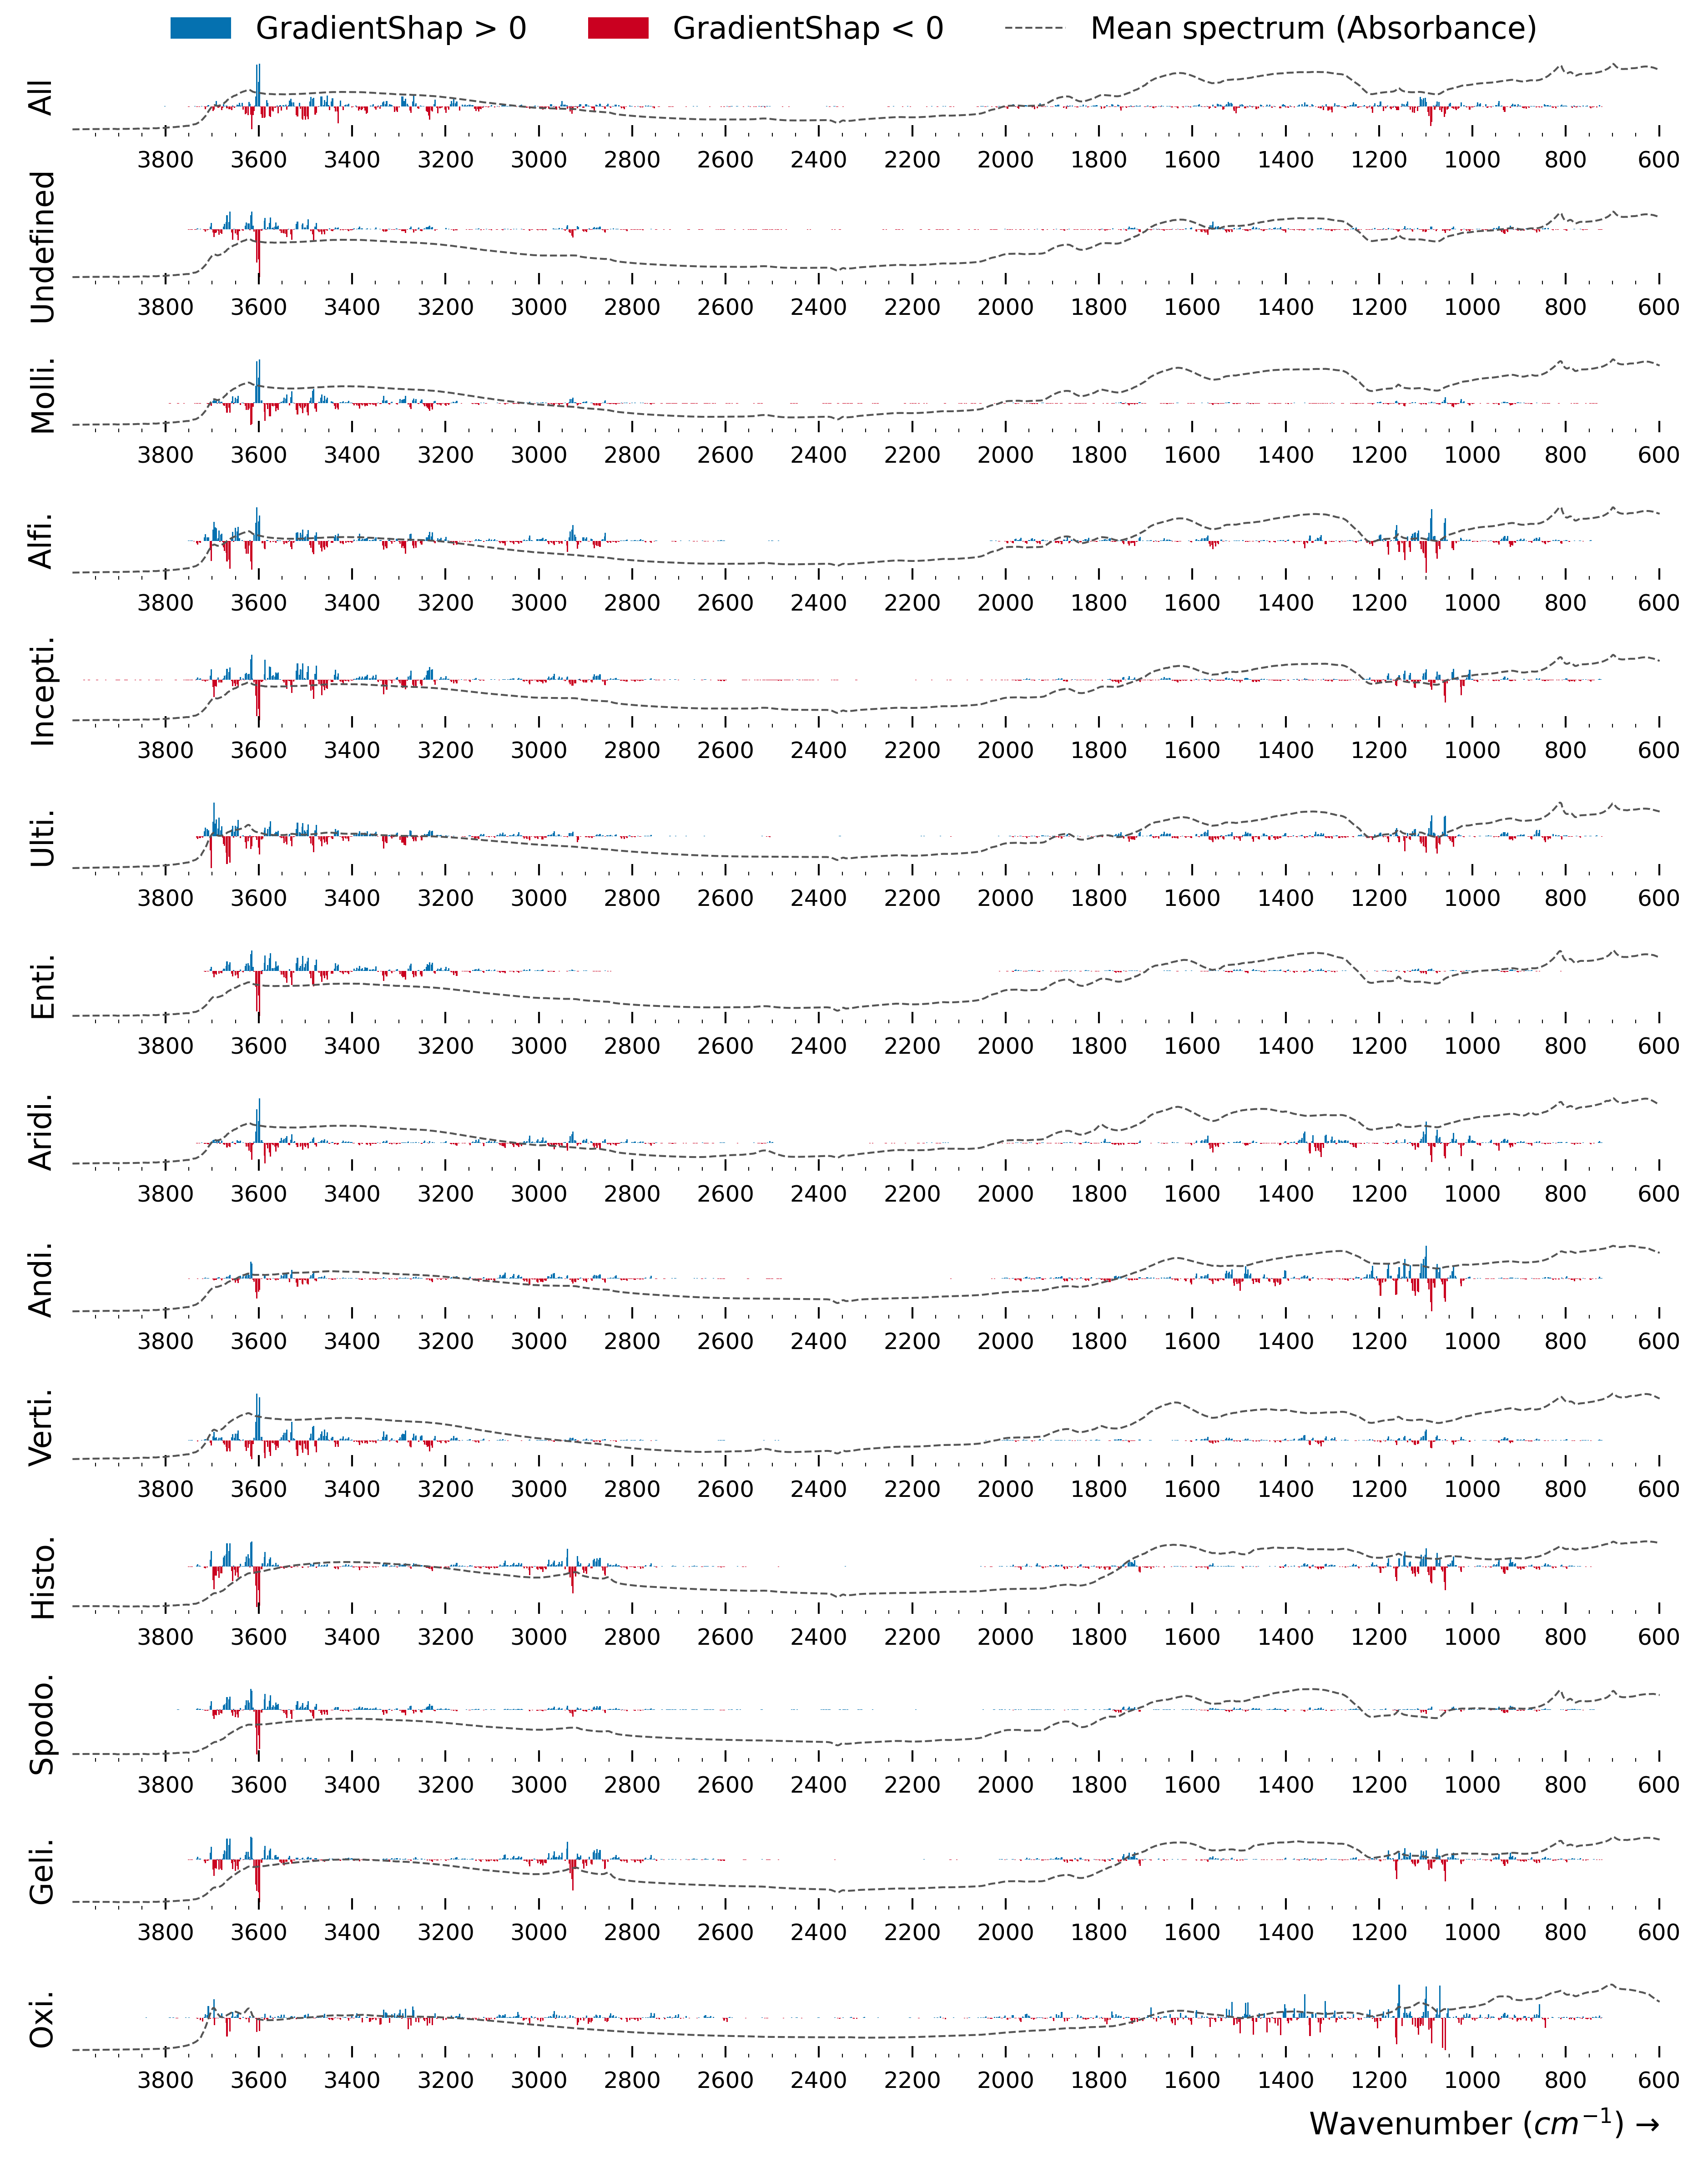

In [ ]:
#FIG_PATH = Path('nameofyourfolder')
FIG_PATH = Path('/content/drive/MyDrive/research/predict-k-mirs-dl/img')
fname = 'gradshap-order-02092022.png'

set_style(DEFAULT_STYLE)
plot_shaps_by_orders(shap_by_order, X_mean_by_order, X_names, tax_pretty_lut,
                     figsize=(16*centimeter, 20*centimeter), diverging=True)


plt.savefig(FIG_PATH/fname, dpi=600, transparent=True, format='png')